In [21]:
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

nvidia = yf.Ticker("NVDA")
history_nvidia = nvidia.history(period = '1y')

#removing hours from data
history_nvidia.index = history_nvidia.index.date
history_nvidia.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2023-11-24,48.455345,48.906209,47.730562,47.761555,294645000,0.0,0.0
2023-11-27,47.785538,48.515317,47.637584,48.227406,395662000,0.0,0.0
2023-11-28,48.221413,48.308389,47.458643,47.806538,401491000,0.0,0.0
2023-11-29,48.364372,48.747256,47.845528,48.125443,382005000,0.0,0.0
2023-11-30,48.009470,48.095447,46.407957,46.755852,526247000,0.0,0.0


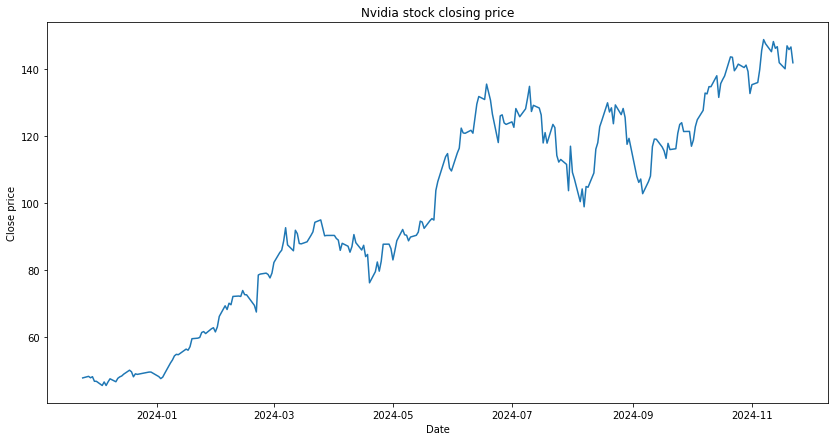

In [22]:
from matplotlib import pyplot as plt
import numpy as np 

nvidia_close_price = history_nvidia['Close']

plt.figure(figsize=(14,7))
plt.plot(nvidia_close_price)
plt.title("Nvidia stock closing price")
plt.xlabel("Date")
plt.ylabel("Close price")

plt.show()

### Assume that $S_{i}$ is a stock price in time $i$, the return is expressed by formula 
$$return_{i+1} = \frac{S_{i+1} - S_{i}}{S_i}$$

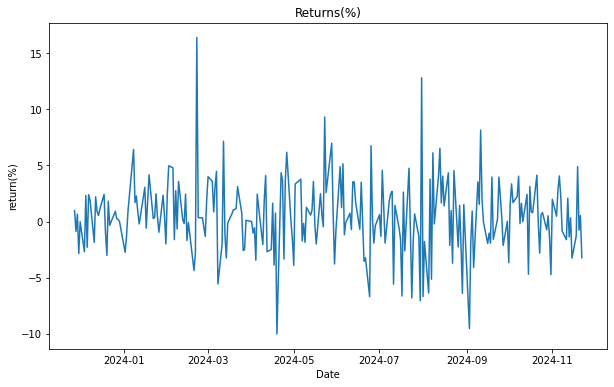

In [23]:
# returns 
returns = nvidia_close_price.pct_change()*100

plt.figure(figsize = (10, 6))
plt.plot(returns)
plt.title("Returns(%)")
plt.xlabel("Date")
plt.ylabel("return(%)")

plt.show()

### $$Log returns_i = ln\left(\frac{S_{i+1}}{S{i}}\right) $$

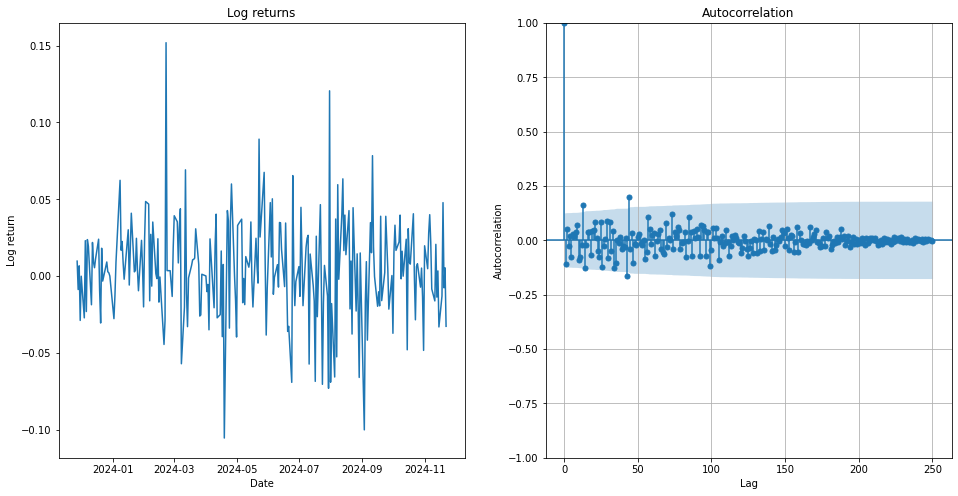

In [24]:
# log returns
## explore stationarity of time series
from statsmodels.graphics.tsaplots import plot_acf, acf
fig, axes = plt.subplots(1, 2, figsize=(16,8))

history_nvidia["log_returns"] = np.log(nvidia_close_price/nvidia_close_price.shift(1))
log_returns = history_nvidia["log_returns"].dropna()
log_returns

axes[0].plot(log_returns)
axes[0].set_title("Log returns")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Log return")

plot_acf(log_returns, ax = axes[1], lags = len(log_returns) - 1)
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Autocorrelation")
axes[1].grid()

plt.show()

#### The plot of autocorrelation suggests that it may be a stationary process; however, occasional anomalies exceed the rejection region. Therefore, it is recommended to also perform stationarity tests such as the Dickey-Fuller test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. 

### The Dickey Fuller test assume: 
- $H_0$ - the series has a unit root (series is nonstationary)
- $H_1$ - the series has no unit root (series are stationary)

In [25]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_test = adfuller(log_returns)

print('p-value:', adf_test[1])

p-value: 4.359124058782017e-30


#### Based on the p-value, the null hypothesis can be rejected at the significance level $\alpha = 0.05$.

#### KPSS test:
- H_0 - the process is trend stationary.
- H_1 - the series has a unit root (series is not stationary). 

In [26]:
kpss_test = kpss(log_returns)
print('p-value:', kpss_test[1])

p-value: 0.1


#### There is not enough evidence to reject the null hypothesis at the significance level $\alpha = 0.05$

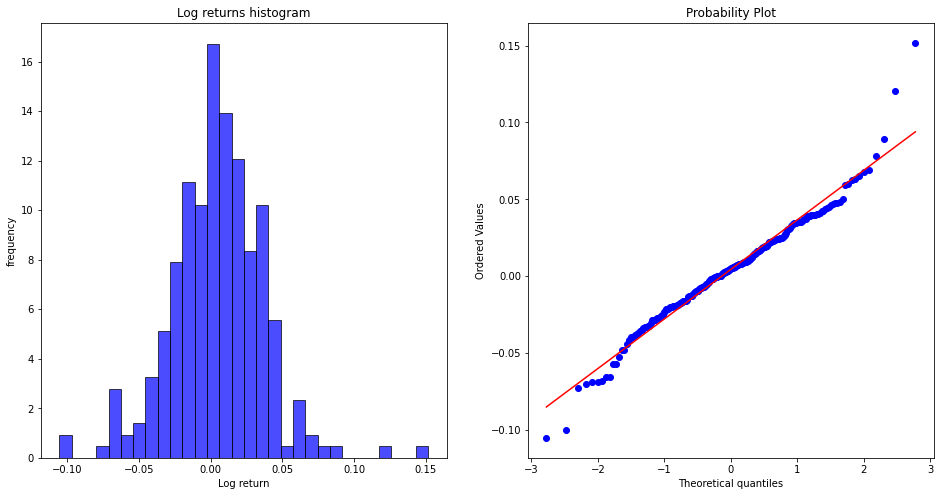

In [27]:
# log returns
from scipy.stats import probplot

fig, axes = plt.subplots(1, 2, figsize=(16,8))

axes[0].hist(log_returns, bins=30, density = True, alpha = 0.7, color='blue', edgecolor='black')
axes[0].set_title("Log returns histogram")
axes[0].set_xlabel("Log return")
axes[0].set_ylabel("frequency")

probplot(log_returns, plot = axes[1])

plt.show()

### Estimating parameter from data
- The diffusion is estimated by:
    - diffusion_1 = $\sqrt{252*\frac{1}{n}\sum_{i = 1}^{n}{(u_i - \bar{u}_i)^2}}$
    - diffusion_2 = $\sqrt{\frac{1}{n-1}\sum_{i = 1}^{n}{u_i^2} - \frac{1}{n(n - 1)}(\sum_{i = 1}^{n}{u_i})^2}*\sqrt{252}$
-  drift is estimated by:
    - drift = $(\mu - \frac{\sigma_1^2}{2})*252$, where $\mu$ is expected return and $\sigma_1^2$ is estimator of variance 

In [28]:
returns = nvidia_close_price.pct_change().dropna()

diffusion_1 = log_returns.std()*np.sqrt(252)

len_log_return = len(log_returns) 

a = np.mean(np.power(log_returns, 2))*(len_log_return/(len_log_return-1))
b = 1/(len_log_return *(len_log_return -1))
c = np.power(np.sum(log_returns), 2)

sigma_square = (a - b * c)*252.
diffusion_2 = np.sqrt(sigma_square)
 

In [29]:
mu = np.mean(log_returns)
drift = (mu - 0.5*sigma_square/252)*252

print(f"Drift coefficient;{drift}\nDiffusion coefficient:{diffusion_2}")

Drift coefficient;0.9600818096659852
Diffusion coefficient:0.5167430448704291


In [30]:
se = diffusion_1/np.sqrt(2*len(log_returns))
print(f"Standard error of this estimate is: {se}.")

Standard error of this estimate is: 0.023063370797732706.


In [31]:
def BS_simulation_Mil(seed: int, S0: float, drift: float, diffusion: float, T: float, dt: float) -> np.ndarray:
    """  approximate numerical solution of a stochastic differential equation using Milstein method
    Args:
        seed (int): determines the sequence of random numbers generated.
        S0 (float): initial price.
        diffusion (float): volatility parameter .
        drift (float): Drift parameter (mean rate of change per unit time).
        T (Float): time expressed by year.
        dt (float): time step size.

    Returns:
    np.ndarray: An array of shape (n_steps, 2), where:
        - The first column contains the time steps.
        - The second column contains the stock prices at each time steps using Milstein method.
    """

    np.random.seed(seed)
    N = int(T / dt)
    times = np.linspace(0, T, N)
    stock_price = np.zeros(N)
    stock_price[0] = S0
    
    for i in range(1, N):
        t = times[i - 1]
        derivative = (diffusion * (stock_price[i - 1] +  10**(-6)) - diffusion * (stock_price[i - 1]))/10**(-6) 
        
        a = drift * stock_price[i - 1]
        b = diffusion * stock_price[i - 1]
        
        dS = a * dt + b * np.sqrt(dt) * np.random.normal() + 0.5 * b * derivative * (dt * np.power(np.random.normal(), 2) - dt)
        stock_price[i] = stock_price[i - 1] + dS
    
    return times, stock_price   

In [32]:
import random 

def BS_simulation_EM(seed: int, S0: float, drift: float, diffusion: float, T: float, dt: float) -> np.ndarray:
    """  approximate numerical solution of a stochastic differential equation using Euler-Maruyama method
    Args:
        seed (int): determines the sequence of random numbers generated.
        S0 (float): initial price.
        diffusion (float): volatility parameter .
        drift (float): Drift parameter (mean rate of change per unit time).
        T (Float): time expressed by year.
        dt (float): time step size.

    Returns:
    np.ndarray: An array of shape (n_steps, 2), where:
        - The first column contains the time steps.
        - The second column contains the stock prices at each time steps using Euler-Maruyama method.
    """
    np.random.seed(seed)
    N = int(T / dt)
    times = np.linspace(0, T, N)
    stock_price = np.zeros(N )
    stock_price[0] = S0
    
    for i in range(1, N):
        t = times[i - 1]
        dS = drift * stock_price[i - 1] * dt + diffusion * stock_price[i - 1] * np.sqrt(dt) * np.random.normal()
        stock_price[i] = stock_price[i - 1] + dS
    
    return times, stock_price   

In [33]:
T = 1.0
dt = 1/252
seed = 123
S0 = nvidia_close_price.iloc[0]

BS_simulation_EM_path = BS_simulation_EM(seed, S0, drift, diffusion_2, T, dt)
BS_simulation_Mil_path = BS_simulation_Mil(seed, S0, drift, diffusion_2, T, dt)

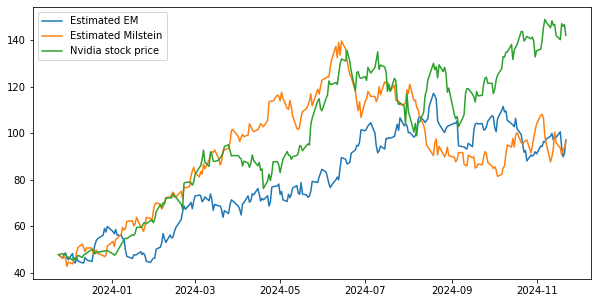

In [34]:
plt.figure(figsize=(10,5))
plt.plot(history_nvidia.index, BS_simulation_EM_path[1], label = "Estimated EM")
plt.plot(history_nvidia.index, BS_simulation_Mil_path[1], label = "Estimated Milstein")
plt.plot(history_nvidia.index, nvidia_close_price, label = "Nvidia stock price")
plt.legend()

plt.show()